<a href="https://www.kaggle.com/code/orjiugochukwu/twitter-sentiment-analysis?scriptVersionId=106035557" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

* **Natural Language Processing (NLP):** This is a field of artificial intelligence that is concerned with creating a means of communicating with intelligent systems using a natural language such as English.

* **Twitter Sentiment Analysis:** Twitter sentiment analysis is a specialized area within sentiment analysis used to extract opinions/expressions from tweets like product sentiments.

In this notebook, we'll develop a **Twitter Sentiment Analysis model** to categorize a tweet as **Positive or Negative.**


## Table of Contents
1. [Importing dependencies](#p1)
2. [Importing dataset](#p2)
3. [Text Preprocessing](#p3)
4. [Data Analysis](#p4)
5. [Splitting data](#p5)
6. [TF-IDF Vectoriser](#p6)
7. [Transforming Dataset](#p7)
8. [Model Development and Evaluation](#p8)
    * [BernoulliNB Model](#p8-1)
    * [LinearSVC Model](#p8-2)
    * [Logistic Regression Model](#p8-3)
9. [Saving the Models](#p9)
10. [Testing the Model](#p10)

## <a name="p1">Importing the needed libraries</a>

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## <a name="p2">Importing dataset</a>
The dataset used for this project is **sentiment140 dataset**, it contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.
 
**The Dataset contains the following fields:**
1. **sentiment**: the classification of the tweets *(0 = negative, 4 = positive)*
2. **ids**:  tweet id 
3. **date**: tweet date 
4. **flag**: The query.
5. **user**: username of tweeps 
6. **text**: the text of the tweet

For this project only the **sentiment** and **text** fields are required, so we drop the rest.

Furthermore, the **sentiment** field will be changed to reflect new sentiment format as follows **(0 = Negative, 1 = Positive)**

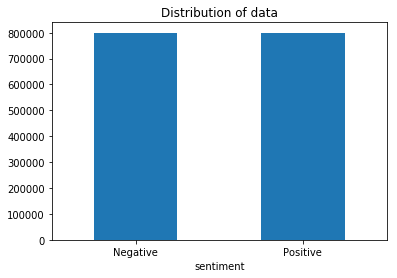

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## <a name="p3">Text Preprocessing</a>
**Text Preprocessing** at this stage, the text is preprocessed and standardized for analysis and model development.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** **"http", "https" & "www"** are replaced with **"URL"**.
3. **Replacing Emojis:** Emojis are replaced with a pre-defined dictionary alternative
4. **Replacing Usernames:** Usernames are standardized. 
5. **Removing Non-Alphabets:** Only retaining Digits, Alphabets and space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are shortened
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. 
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Walking” to “Walk”)*

In [3]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [4]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [5]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 147 seconds


## <a name="p4">Data Analysis</a>
Here, we're going to use visualization to quickly explore the preprocessed data in a bid to uncover any implicit patterns, spot anomalies, and check assumptions. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

### Word-Cloud for Negative tweets.

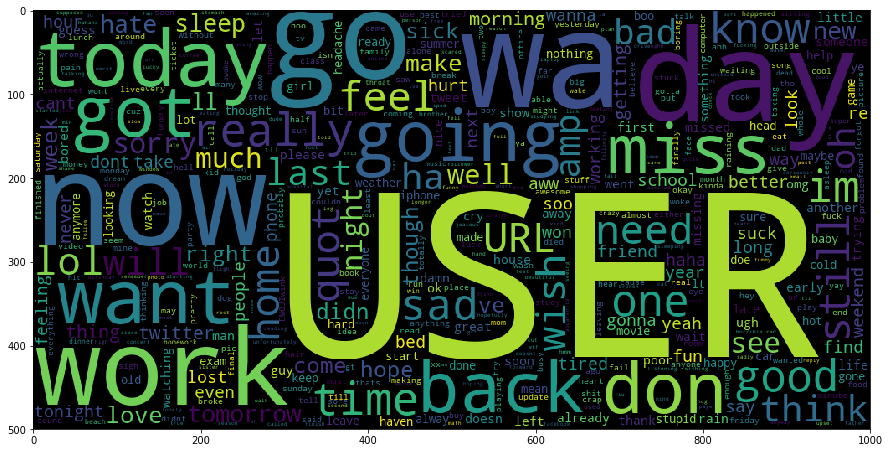

In [6]:
data_neg = processedtext[:800000]
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word-Cloud for Positive tweets.

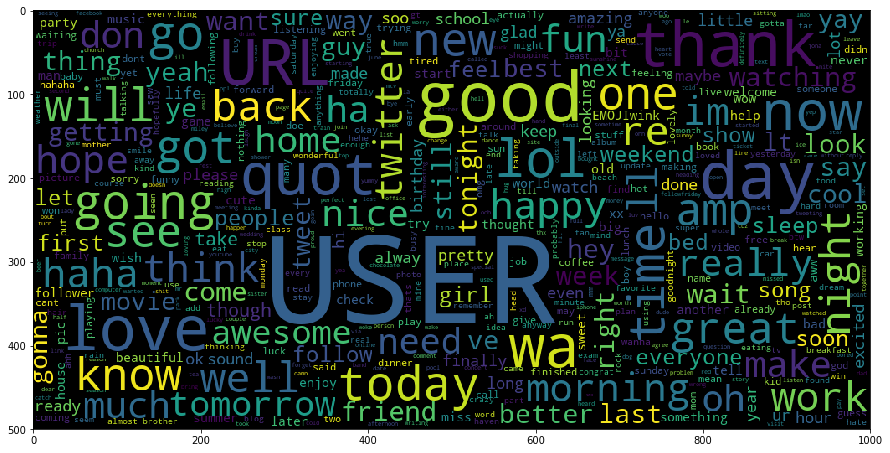

In [7]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 500 , width = 1000 , height = 500,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (15,15))
plt.imshow(wc)

## <a name="p5">Splitting the Data</a>
The Preprocessed Data is split into;
* **Training set:** Containing 90% of the data.
* **Test set:** Containing 10% of the data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.20, random_state = 2)
print(f'Data Split done.')

Data Split done.


## <a name="p6">TF-IDF Vectoriser</a>
**TF-IDF Vectoriser** transforms the text into a usable vector. 
**ngram_range** is a string of n words in a row
**max_features** specifies the number of features to consider. 

In [9]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


### <a name="p7">Tranforming the dataset</a>
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. This datasets will be used to train the model and test against it.

In [10]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## <a name="p8">Model Development and Evaluation</a>

In this project, we used 3 machine learning models for our Twitter sentiment analysis problem: 
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

The evaluation metric used in this project is the **Precision-Recall Metrics**. We also plotted the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### Evaluate Model Function

In [11]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### <a name="p8-1">BernoulliNB Model</a>

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    160041
           1       0.80      0.81      0.80    159959

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



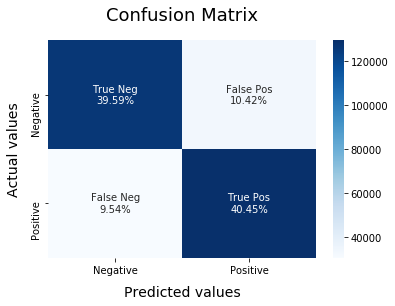

In [12]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
acc_BNB= model_Evaluate(BNBmodel)

### <a name="p8-2">LinearSVC Model</a>

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    160041
           1       0.81      0.82      0.81    159959

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



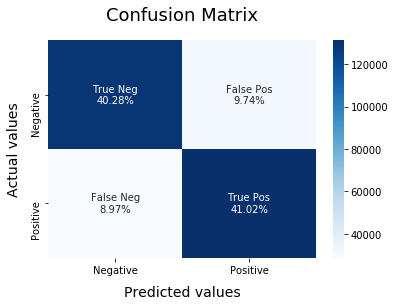

In [13]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
acc_SVC= model_Evaluate(SVCmodel)

### <a name="p8-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    160041
           1       0.82      0.83      0.83    159959

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



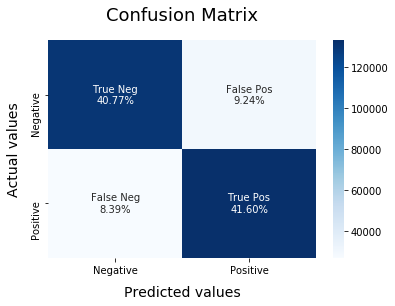

In [14]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
acc_LR= model_Evaluate(LRmodel)

### <a name="p8-3">Inference</a>
When compared between the three machine learning algorithms, Logistic Regression achieved a better performance with an accuracy of 83%; however, Bernoulli Naive Bayes is the fastest to train and predict.

## <a name="p9">Saving the Models</a>
We're using **PICKLE** to save **Vectoriser, SVCmodel, and Logistic Regression Model** for later use.

In [15]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

## <a name="p10">Testing the Model</a>

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **LR Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features while the model can be used to predict the sentiment of the transformed Data.          
**Please Note:** Before sentiment analysis is performed on any text, it must be preprocessed.

In [16]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    #Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['Text','Sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["This minimie tastes weird",
            "Dogecoin is a big flop",
            "I like eating catfish",
           "Bigi drinks is cheaper and tastes the same as coke"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                                                Text Sentiment
0                          This minimie tastes weird  Negative
1                             Dogecoin is a big flop  Negative
2                              I like eating catfish  Positive
3  Bigi drinks is cheaper and tastes the same as ...  Positive


**Acknowledgement; We'd like to appreciate Nikit Periwal (https://www.kaggle.com/stoicstatic) for his eye-opening Notebook.**